## COGS 181 Final Project

Anni Li

### Description

### Environment Preparation

In [132]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [135]:
# unzip the dataset
!tar -xvzf CUB_200_2011.tgz -q

In [51]:
# set up the device
if torch.cuda.is_available():
    device = torch.device("cuda")          
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('Using CPU')

Using GPU: NVIDIA GeForce RTX 3070 Laptop GPU


In [52]:
# avoid CUDA errors
CUDA_LAUNCH_BLOCKING=1

### Data Processing

#### Combine the necessary .txt files in the dataset package into one data frame

In [2]:
labels = pd.read_csv("CUB_200_2011/image_class_labels.txt", header=None, sep = " ")
labels.columns = ["id", "label"]

In [3]:
species = pd.read_csv("CUB_200_2011/classes.txt", header=None, sep = " ")
species.columns = ["label", "species"]

In [4]:
train_test = pd.read_csv("CUB_200_2011/train_test_split.txt", header=None, sep=" ")
train_test.columns = ["id", "is_train"]

In [5]:
image_names = pd.read_csv("CUB_200_2011/images.txt", header=None, sep=" ")
image_names.columns = ["id", "image_name"]

In [72]:
classes = pd.read_csv("CUB_200_2011/classes.txt", header=None, sep = " ")
classes.columns = ["label", "species"]
classes["label"] = classes["label"] - 1
classes

,label,species
0,0,001.Black_footed_Albatross
1,1,002.Laysan_Albatross
2,2,003.Sooty_Albatross
3,3,004.Groove_billed_Ani
4,4,005.Crested_Auklet
...,...,...
195,195,196.House_Wren
196,196,197.Marsh_Wren
197,197,198.Rock_Wren
198,198,199.Winter_Wren


In [6]:
data = pd.merge(image_names, train_test, on="id")
data = pd.merge(data, labels, on="id")
data = pd.merge(data, species, on="label")
data["label"] = data["label"] - 1
data

,id,image_name,is_train,label,species
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...,0,0,001.Black_footed_Albatross
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...,1,0,001.Black_footed_Albatross
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...,0,0,001.Black_footed_Albatross
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...,1,0,001.Black_footed_Albatross
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...,1,0,001.Black_footed_Albatross
...,...,...,...,...,...
11783,11784,200.Common_Yellowthroat/Common_Yellowthroat_00...,1,199,200.Common_Yellowthroat
11784,11785,200.Common_Yellowthroat/Common_Yellowthroat_00...,0,199,200.Common_Yellowthroat
11785,11786,200.Common_Yellowthroat/Common_Yellowthroat_00...,0,199,200.Common_Yellowthroat
11786,11787,200.Common_Yellowthroat/Common_Yellowthroat_00...,1,199,200.Common_Yellowthroat


#### Define the dataset class and necessary data processing functions

In [7]:
class CUBdata(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image = Image.open( "CUB_200_2011/images/" + self.data.loc[index, "image_name"]).convert("RGB")
        label = self.data.loc[index, "label"]
        if self.transform is not None:
            image = self.transform(image)
            image = normalize_image(image)
        return image, label

In [8]:
transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor()
])

In [9]:
def normalize_image(tensorimage):
    image_min = tensorimage.min()
    image_max = tensorimage.max()
    tensorimage.clamp_(min=image_min, max=image_max)
    tensorimage.add_(-image_min).div_(image_max - image_min + 1e-5)
    return tensorimage

#### Plot some images with labels to have a look

In [49]:
def plot_images(images, labels, normalize=True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig, axs = plt.subplots(rows, cols, figsize = (15,15))
    axs = axs.ravel() 
    for i in range(rows*cols):
        image = Image.open("CUB_200_2011/images/" + images[i]).convert('RGB')
        image = transform(image)
        if normalize:
            image = normalize_image(image)
        image = image.numpy()
        
        axs[i].imshow(np.transpose(image, (1, 2, 0)))
        label = labels[i]
        axs[i].set_title(label)
        axs[i].set_axis_off()

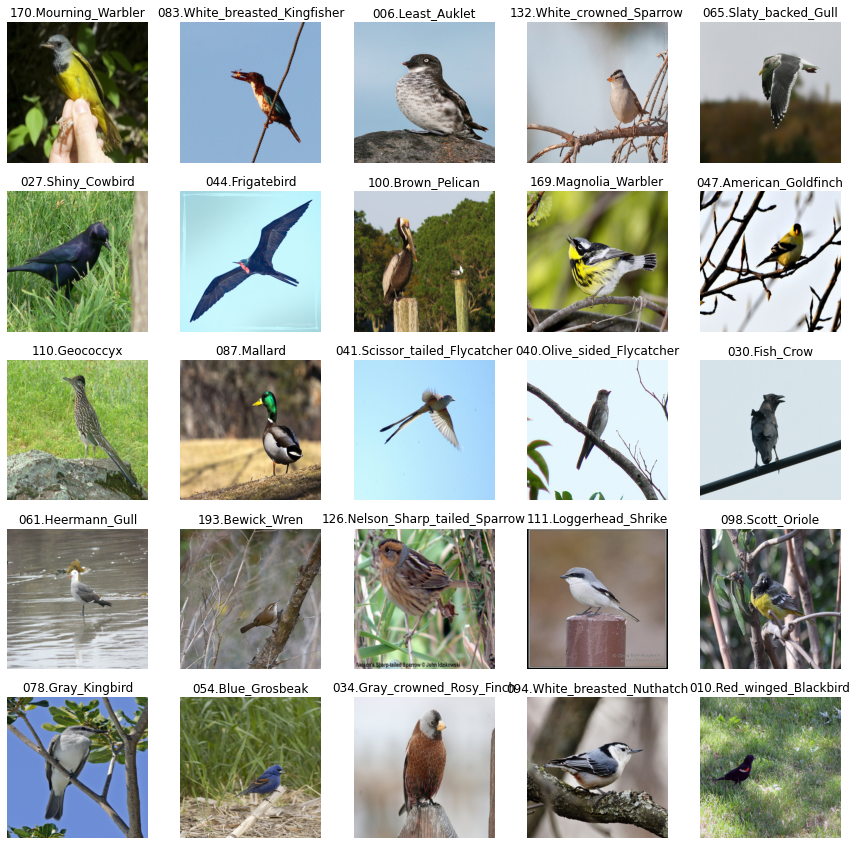

In [50]:
imagelist = []
labellist = []
randomlist = [random.randint(0, len(data)) for _ in range(25)]
for i in randomlist:
    imagelist.append(data.loc[i, 'image_name'])
    labellist.append(data.loc[i, 'species'])
plot_images(imagelist, labellist)

#### Define the data loader and CNN model

In [53]:
train_data = data[data["is_train"] == 1]
train_data = train_data.reset_index(drop=True)
trainset = CUBdata(train_data, transform=transform)
trainloader = DataLoader(trainset, batch_size=4, shuffle=True)

test_data = data[data["is_train"] == 0]
test_data = test_data.reset_index(drop=True)
testset = CUBdata(test_data, transform=transform)
testloader = DataLoader(testset, batch_size=4, shuffle=False)

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(32 * 112 * 112, 200)
        
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        return x

In [13]:
net = Net()
net.to(device)
loss_func = nn.CrossEntropyLoss().to(device)
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 

### Training

In [16]:
avg_losses = []
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, trainstat in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, ytrue = trainstat
        inputs, ytrue = inputs.to(device), ytrue.to(device)
        # zero the parameter gradients
        opt.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_func(outputs, ytrue)
        loss.backward()
        opt.step()

        # print statistics
        running_loss += loss.item()
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss))
        running_loss = 0.0
        
print('Finished Training')

[1,     1] loss: 5.285
[1,     2] loss: 1.684
[1,     3] loss: 0.078
[1,     4] loss: 0.001
[1,     5] loss: 0.000
[1,     6] loss: 0.000
[1,     7] loss: 0.000
[1,     8] loss: 20.269
[1,     9] loss: 40.873
[1,    10] loss: 5.383
[1,    11] loss: 5.283
[1,    12] loss: 5.182
[1,    13] loss: 4.998
[1,    14] loss: 4.777
[1,    15] loss: 4.321
[1,    16] loss: 5.326
[1,    17] loss: 5.225
[1,    18] loss: 4.797
[1,    19] loss: 3.912
[1,    20] loss: 2.359
[1,    21] loss: 0.574
[1,    22] loss: 0.005
[1,    23] loss: 7.633
[1,    24] loss: 12.455
[1,    25] loss: 6.206
[1,    26] loss: 5.302
[1,    27] loss: 5.300
[1,    28] loss: 5.299
[1,    29] loss: 5.299
[1,    30] loss: 5.298
[1,    31] loss: 5.299
[1,    32] loss: 5.298
[1,    33] loss: 5.296
[1,    34] loss: 5.293
[1,    35] loss: 5.290
[1,    36] loss: 5.285
[1,    37] loss: 5.281
[1,    38] loss: 5.287
[1,    39] loss: 5.298
[1,    40] loss: 5.296
[1,    41] loss: 5.294
[1,    42] loss: 5.291
[1,    43] loss: 5.287
[1,    4

[1,   360] loss: 5.300
[1,   361] loss: 5.300
[1,   362] loss: 5.300
[1,   363] loss: 5.300
[1,   364] loss: 5.300
[1,   365] loss: 5.300
[1,   366] loss: 5.300
[1,   367] loss: 5.300
[1,   368] loss: 5.300
[1,   369] loss: 5.300
[1,   370] loss: 5.300
[1,   371] loss: 5.300
[1,   372] loss: 5.300
[1,   373] loss: 5.300
[1,   374] loss: 5.300
[1,   375] loss: 5.300
[1,   376] loss: 5.300
[1,   377] loss: 5.300
[1,   378] loss: 5.300
[1,   379] loss: 5.300
[1,   380] loss: 5.300
[1,   381] loss: 5.300
[1,   382] loss: 5.300
[1,   383] loss: 5.300
[1,   384] loss: 5.300
[1,   385] loss: 5.300
[1,   386] loss: 5.300
[1,   387] loss: 5.300
[1,   388] loss: 5.300
[1,   389] loss: 5.300
[1,   390] loss: 5.300
[1,   391] loss: 5.300
[1,   392] loss: 5.300
[1,   393] loss: 5.300
[1,   394] loss: 5.300
[1,   395] loss: 5.300
[1,   396] loss: 5.300
[1,   397] loss: 5.300
[1,   398] loss: 5.300
[1,   399] loss: 5.300
[1,   400] loss: 5.300
[1,   401] loss: 5.300
[1,   402] loss: 5.300
[1,   403] 

[1,   719] loss: 5.299
[1,   720] loss: 5.299
[1,   721] loss: 5.299
[1,   722] loss: 5.299
[1,   723] loss: 5.299
[1,   724] loss: 5.299
[1,   725] loss: 5.299
[1,   726] loss: 5.299
[1,   727] loss: 5.299
[1,   728] loss: 5.299
[1,   729] loss: 5.299
[1,   730] loss: 5.299
[1,   731] loss: 5.299
[1,   732] loss: 5.299
[1,   733] loss: 5.299
[1,   734] loss: 5.299
[1,   735] loss: 5.299
[1,   736] loss: 5.299
[1,   737] loss: 5.299
[1,   738] loss: 5.299
[1,   739] loss: 5.299
[1,   740] loss: 5.299
[1,   741] loss: 5.299
[1,   742] loss: 5.299
[1,   743] loss: 5.299
[1,   744] loss: 5.299
[1,   745] loss: 5.299
[1,   746] loss: 5.299
[1,   747] loss: 5.299
[1,   748] loss: 5.299
[1,   749] loss: 5.299
[1,   750] loss: 5.299
[1,   751] loss: 5.299
[1,   752] loss: 5.299
[1,   753] loss: 5.299
[1,   754] loss: 5.299
[1,   755] loss: 5.299
[1,   756] loss: 5.299
[1,   757] loss: 5.299
[1,   758] loss: 5.299
[1,   759] loss: 5.299
[1,   760] loss: 5.299
[1,   761] loss: 5.299
[1,   762] 

[1,  1078] loss: 5.299
[1,  1079] loss: 5.299
[1,  1080] loss: 5.299
[1,  1081] loss: 5.299
[1,  1082] loss: 5.299
[1,  1083] loss: 5.299
[1,  1084] loss: 5.299
[1,  1085] loss: 5.299
[1,  1086] loss: 5.299
[1,  1087] loss: 5.299
[1,  1088] loss: 5.299
[1,  1089] loss: 5.299
[1,  1090] loss: 5.299
[1,  1091] loss: 5.299
[1,  1092] loss: 5.299
[1,  1093] loss: 5.299
[1,  1094] loss: 5.299
[1,  1095] loss: 5.299
[1,  1096] loss: 5.299
[1,  1097] loss: 5.299
[1,  1098] loss: 5.299
[1,  1099] loss: 5.299
[1,  1100] loss: 5.299
[1,  1101] loss: 5.299
[1,  1102] loss: 5.299
[1,  1103] loss: 5.299
[1,  1104] loss: 5.299
[1,  1105] loss: 5.299
[1,  1106] loss: 5.299
[1,  1107] loss: 5.299
[1,  1108] loss: 5.299
[1,  1109] loss: 5.299
[1,  1110] loss: 5.299
[1,  1111] loss: 5.299
[1,  1112] loss: 5.299
[1,  1113] loss: 5.299
[1,  1114] loss: 5.299
[1,  1115] loss: 5.299
[1,  1116] loss: 5.299
[1,  1117] loss: 5.299
[1,  1118] loss: 5.299
[1,  1119] loss: 5.299
[1,  1120] loss: 5.299
[1,  1121] 

[1,  1435] loss: 5.298
[1,  1436] loss: 5.298
[1,  1437] loss: 5.298
[1,  1438] loss: 5.298
[1,  1439] loss: 5.298
[1,  1440] loss: 5.298
[1,  1441] loss: 5.298
[1,  1442] loss: 5.298
[1,  1443] loss: 5.298
[1,  1444] loss: 5.298
[1,  1445] loss: 5.298
[1,  1446] loss: 5.298
[1,  1447] loss: 5.298
[1,  1448] loss: 5.298
[1,  1449] loss: 5.298
[1,  1450] loss: 5.298
[1,  1451] loss: 5.298
[1,  1452] loss: 5.298
[1,  1453] loss: 5.298
[1,  1454] loss: 5.298
[1,  1455] loss: 5.298
[1,  1456] loss: 5.298
[1,  1457] loss: 5.298
[1,  1458] loss: 5.298
[1,  1459] loss: 5.298
[1,  1460] loss: 5.298
[1,  1461] loss: 5.298
[1,  1462] loss: 5.298
[1,  1463] loss: 5.298
[1,  1464] loss: 5.298
[1,  1465] loss: 5.298
[1,  1466] loss: 5.298
[1,  1467] loss: 5.298
[1,  1468] loss: 5.298
[1,  1469] loss: 5.298
[1,  1470] loss: 5.298
[1,  1471] loss: 5.298
[1,  1472] loss: 5.298
[1,  1473] loss: 5.298
[1,  1474] loss: 5.298
[1,  1475] loss: 5.298
[1,  1476] loss: 5.298
[1,  1477] loss: 5.298
[1,  1478] 

[2,   295] loss: 5.299
[2,   296] loss: 5.299
[2,   297] loss: 5.299
[2,   298] loss: 5.299
[2,   299] loss: 5.299
[2,   300] loss: 5.299
[2,   301] loss: 5.299
[2,   302] loss: 5.299
[2,   303] loss: 5.299
[2,   304] loss: 5.299
[2,   305] loss: 5.299
[2,   306] loss: 5.299
[2,   307] loss: 5.299
[2,   308] loss: 5.299
[2,   309] loss: 5.299
[2,   310] loss: 5.299
[2,   311] loss: 5.299
[2,   312] loss: 5.299
[2,   313] loss: 5.299
[2,   314] loss: 5.299
[2,   315] loss: 5.299
[2,   316] loss: 5.299
[2,   317] loss: 5.299
[2,   318] loss: 5.299
[2,   319] loss: 5.299
[2,   320] loss: 5.299
[2,   321] loss: 5.299
[2,   322] loss: 5.299
[2,   323] loss: 5.299
[2,   324] loss: 5.299
[2,   325] loss: 5.299
[2,   326] loss: 5.299
[2,   327] loss: 5.299
[2,   328] loss: 5.299
[2,   329] loss: 5.299
[2,   330] loss: 5.299
[2,   331] loss: 5.299
[2,   332] loss: 5.299
[2,   333] loss: 5.299
[2,   334] loss: 5.299
[2,   335] loss: 5.299
[2,   336] loss: 5.299
[2,   337] loss: 5.299
[2,   338] 

[2,   655] loss: 5.299
[2,   656] loss: 5.299
[2,   657] loss: 5.299
[2,   658] loss: 5.299
[2,   659] loss: 5.299
[2,   660] loss: 5.299
[2,   661] loss: 5.299
[2,   662] loss: 5.299
[2,   663] loss: 5.299
[2,   664] loss: 5.299
[2,   665] loss: 5.299
[2,   666] loss: 5.299
[2,   667] loss: 5.299
[2,   668] loss: 5.299
[2,   669] loss: 5.299
[2,   670] loss: 5.299
[2,   671] loss: 5.299
[2,   672] loss: 5.299
[2,   673] loss: 5.299
[2,   674] loss: 5.299
[2,   675] loss: 5.299
[2,   676] loss: 5.299
[2,   677] loss: 5.299
[2,   678] loss: 5.299
[2,   679] loss: 5.299
[2,   680] loss: 5.299
[2,   681] loss: 5.299
[2,   682] loss: 5.299
[2,   683] loss: 5.299
[2,   684] loss: 5.299
[2,   685] loss: 5.299
[2,   686] loss: 5.299
[2,   687] loss: 5.299
[2,   688] loss: 5.299
[2,   689] loss: 5.299
[2,   690] loss: 5.299
[2,   691] loss: 5.299
[2,   692] loss: 5.299
[2,   693] loss: 5.299
[2,   694] loss: 5.299
[2,   695] loss: 5.299
[2,   696] loss: 5.299
[2,   697] loss: 5.299
[2,   698] 

[2,  1012] loss: 5.298
[2,  1013] loss: 5.298
[2,  1014] loss: 5.298
[2,  1015] loss: 5.298
[2,  1016] loss: 5.298
[2,  1017] loss: 5.298
[2,  1018] loss: 5.298
[2,  1019] loss: 5.298
[2,  1020] loss: 5.298
[2,  1021] loss: 5.298
[2,  1022] loss: 5.298
[2,  1023] loss: 5.298
[2,  1024] loss: 5.298
[2,  1025] loss: 5.298
[2,  1026] loss: 5.298
[2,  1027] loss: 5.298
[2,  1028] loss: 5.298
[2,  1029] loss: 5.298
[2,  1030] loss: 5.298
[2,  1031] loss: 5.298
[2,  1032] loss: 5.298
[2,  1033] loss: 5.298
[2,  1034] loss: 5.298
[2,  1035] loss: 5.298
[2,  1036] loss: 5.298
[2,  1037] loss: 5.298
[2,  1038] loss: 5.298
[2,  1039] loss: 5.298
[2,  1040] loss: 5.298
[2,  1041] loss: 5.298
[2,  1042] loss: 5.298
[2,  1043] loss: 5.298
[2,  1044] loss: 5.298
[2,  1045] loss: 5.298
[2,  1046] loss: 5.298
[2,  1047] loss: 5.298
[2,  1048] loss: 5.298
[2,  1049] loss: 5.298
[2,  1050] loss: 5.298
[2,  1051] loss: 5.298
[2,  1052] loss: 5.298
[2,  1053] loss: 5.298
[2,  1054] loss: 5.298
[2,  1055] 

[2,  1369] loss: 5.299
[2,  1370] loss: 5.299
[2,  1371] loss: 5.299
[2,  1372] loss: 5.299
[2,  1373] loss: 5.299
[2,  1374] loss: 5.299
[2,  1375] loss: 5.299
[2,  1376] loss: 5.299
[2,  1377] loss: 5.299
[2,  1378] loss: 5.299
[2,  1379] loss: 5.299
[2,  1380] loss: 5.299
[2,  1381] loss: 5.299
[2,  1382] loss: 5.299
[2,  1383] loss: 5.299
[2,  1384] loss: 5.299
[2,  1385] loss: 5.299
[2,  1386] loss: 5.299
[2,  1387] loss: 5.299
[2,  1388] loss: 5.299
[2,  1389] loss: 5.299
[2,  1390] loss: 5.299
[2,  1391] loss: 5.299
[2,  1392] loss: 5.299
[2,  1393] loss: 5.299
[2,  1394] loss: 5.299
[2,  1395] loss: 5.299
[2,  1396] loss: 5.299
[2,  1397] loss: 5.299
[2,  1398] loss: 5.299
[2,  1399] loss: 5.299
[2,  1400] loss: 5.299
[2,  1401] loss: 5.299
[2,  1402] loss: 5.299
[2,  1403] loss: 5.299
[2,  1404] loss: 5.299
[2,  1405] loss: 5.299
[2,  1406] loss: 5.299
[2,  1407] loss: 5.299
[2,  1408] loss: 5.299
[2,  1409] loss: 5.299
[2,  1410] loss: 5.299
[2,  1411] loss: 5.299
[2,  1412] 

### Evaluate

In [55]:
correct = 0
total = 0
with torch.no_grad():
    for teststat in testloader:
        inputs, ytrue = teststat
        inputs, ytrue = inputs.to(device), ytrue.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += ytrue.size(0)
        correct += (predicted == ytrue).sum().item()

print('Accuracy of the network on the %d test images: %d %%' % 
      (len(testset), 100 * correct / total))


Accuracy of the network on the 5794 test images: 0 %


### Randomly test a image prediction

In [130]:
def display_prediction(image, species, probability):
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Predicted species: {species}\nProbability: {probability:.2f}')
    plt.show()

The random index is 7247


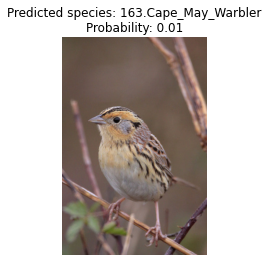

In [131]:
example_idx = random.randint(0, len(data))
example = Image.open("CUB_200_2011/images/" + data.loc[example_idx, "image_name"])
example_tensor = transform(example).unsqueeze(0).to(device)

with torch.no_grad():
    output = net(example_tensor)
    probabilities = F.softmax(output, dim=1)
    
pred_label = torch.argmax(probabilities).item()
pred_species = classes.loc[classes["label"]==pred_label]["species"].values[0]

print(f"The random index is {example_idx}")
display_prediction(example, pred_species, probabilities[0][pred_label].item())

### Need:
- Testing
- Validation
- metrics
- Loss curve

### Possible improvements:
on data processing: 
- binding box w/ parts
- zero padding to erase background <br>

on model:
- combine with transformer
- mask-CNN
-parameters, batchsize, optimizers, etc